# Détection des mélanomes par apprentissage machine

## Introduction
Ce notebook présente le développement d’un modèle d’apprentissage machine pour classifier les lésions cutanées en `bénignes` ou `maligne`. Le dataset utilisé provient de l’ISIC (International Skin Imaging Collaboration). Le projet s’appuie sur le transfer learning avec le modèle EfficientNet. Les étapes incluent le prétraitement des données, l’implémentation du modèle, l’entraînement et l’évaluation.

## Importation des bibliothèques
Nous commençons par installer et importer les bibliothèques nécessaires pour notre projet. Ces bibliothèques permettent de manipuler les données, d’afficher des visualisations et de créer le modèle d’apprentissage. Les principales bibliothèques utilisées sont :
- `numpy` et `pandas` pour la manipulation des données,
- `tensorflow.keras` pour la construction du modèle,
- d’autres modules spécifiques pour le prétraitement et la visualisation.

In [107]:
%pip install tensorflow
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install pydot
%pip install pydot graphviz
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.




In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.applications import EfficientNetB0 # type: ignore #ingore the warning
from tensorflow.keras.layers import Concatenate, Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D # type: ignore #ingore the warning
from tensorflow.keras.models import Model, Sequential, load_model # type: ignore #ingore the warning
from tensorflow.keras.optimizers import Adam # type: ignore #ingore the warning
from tensorflow.keras.utils import plot_model # type: ignore #ingore the warning
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore #ingore the warning
from tensorflow.keras.applications.efficientnet import preprocess_input # type: ignore #ingore the warning
from tensorflow.keras.callbacks import TensorBoard # type: ignore #ingore the warning
from tensorflow.keras.metrics import Precision, Recall, Metric # type: ignore #ingore the warning
from keras.saving import register_keras_serializable # type: ignore #ingore the warning

## Détection du matériel (TPU, GPU, CPU)

Cette cellule détecte le matériel disponible (TPU, GPU ou CPU) et configure une stratégie adaptée pour optimiser l'entraînement :

1. **Priorité** : TPU > GPU > CPU.
2. **Stratégie de distribution des calculs** :
   - TPU : Utilisation de `TPUStrategy` pour exécutions distribuées.
   - GPU : Utilisation de `MirroredStrategy` pour un ou plusieurs GPU.
   - CPU : Stratégie par défaut si pas de TPU ou GPU disponible.
3. **Ressources synchronisées** : Le nombre de répliques (`strategy.num_replicas_in_sync`) sera utilisé pour ajuster dynamiquement la taille globale du batch.

Cette configuration optimise l'utilisation des ressources matérielles (en puissance de calcul) disponibles.
Cette cellule est utilisé lorsque nous entraînons notre modèle a distance sur différents services tels que google colab ou kaggle.


In [109]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
#If TPU not found try with GPUs
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy()
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on CPU
Number of accelerators:  1


# Préparation des TFRecords

Cette cellule contient des fonctions pour convertir des images et leurs labels en un format **TFRecord**, utilisé pour stocker et lire efficacement les données dans TensorFlow.  
Nous écrivons un fichier `.tfrecord` à partir d'un DataFrame contenant les chemins des images et leurs labels.


In [ ]:
# --- Utilitaires pour créer des TFRecords ---
# Fonction pour convertir une image en format binaire compatible TFRecord
def _bytes_feature(value):
    """Encode une image en binaire (bytes_list)."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()]))

# Fonction pour convertir un entier (label) en format TFRecord
def _int64_feature(value):
    """Encode un entier (label) en int64_list."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# --- Conversion des données en format TFRecord ---
# Fonction pour combiner une image et son label dans un format TFRecord
def image_example(image, label):
    """Crée un tf.train.Example à partir d'une image et d'un label."""
    feature = {
        'image': _bytes_feature(image),  # Ajoute l'image
        'label': _int64_feature(label)   # Ajoute le label
    }
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()

# --- Écriture des TFRecords ---
# Fonction pour créer un fichier TFRecord depuis un DataFrame de métadonnées
def write_tfrecords(metadata_df, output_path):
    """Écrit un fichier TFRecord contenant les images et leurs labels."""
    
    # Crée le dossier pour les TFRecords s'il n'existe pas
    if not os.path.exists('tfrecords'):
        os.makedirs('tfrecords')
    
    # Ouvre un fichier TFRecord en écriture
    with tf.io.TFRecordWriter(output_path) as writer:
        for _, row in metadata_df.iterrows():
            # Charge et décode l'image depuis le chemin indiqué
            image_path = row['image_path']
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image, channels=3)  # Décode au format RGB
            
            # Récupère le label associé
            label = row['label']
            
            # Convertit l'image et le label en format TFRecord
            tf_example = image_example(image, label)
            
            # Ajoute cet exemple au fichier TFRecord
            writer.write(tf_example)


# Définition des paramètres globaux pour l'entraînement du modèle

Cette cellule définit les paramètres essentiels pour configurer l'entraînement du modèle de deep learning.  
Les réglages incluent la taille des images, la gestion des ressources matérielles (GPU/TPU), les batchs, et le nombre d'époques.

---

### Paramètres principaux :
- **Gestion des ressources :** Détection automatique du GPU/TPU et calcul du batch par réplique.
- **Taille des images :** Toutes les images seront redimensionnées à `100x100 pixels`.
- **Optimisation :** Utilisation de `AUTOTUNE` pour améliorer la performance des pipelines de données.
- **Nombre d'époques :** Fixé à 90, ajustable selon les besoins du modèle.
- **Couche d'entrée :** Définition d'une couche compatible avec des images au format RGB (3 canaux).

In [ ]:
##################################
# rajout conidtion si GPU ou TPU #
##################################
BATCH_SIZE = 32 * strategy.num_replicas_in_sync 

# Taille des images à utiliser (100x100 pixels)
IMAGE_SIZE = [100, 100]  # Taille utilisée pour le redimensionnement des images
imSize = 100             # Taille utilisée pour redimensionner les images dans les pipelines

# Optimisation automatique pour le préchargement des données
AUTO = tf.data.experimental.AUTOTUNE

# Nombre d'époques (itérations sur l'ensemble d'entraînement)
EPOCHS = 90  # Peut être ajusté en fonction des performances et de la convergence

# Définir l'entrée du modèle (couche d'entrée pour TensorFlow/Keras)
input_layer = Input(shape=(imSize, imSize, 3))  # Entrée avec une image RGB (3 canaux)

## Chargement et préparation des données

Dans cette étape, nous chargeons et préparons les données nécessaires à l'entraînement du modèle.  
Les données sont composées d'images et de métadonnées extraites de plusieurs fichiers CSV :  

- **Données "cutout"** : Métadonnées associées aux images découpées (`cutout`), avec leur label (`benign_malignant`).
- **Données normales** : Métadonnées pour les images normales.
- **Données cliniques** : Métadonnées pour les images respecant les proportions cliniques.

### Étapes principales :
1. **Ajout des chemins d'accès aux images** : Création d'une colonne `image_path` pour pointer vers chaque image.
2. **Mapping des labels** : Conversion des labels `benign_malignant` en valeurs numériques (`0` pour bénin, `1` pour malin).
3. **Traitement des données manquantes** : Suppression des lignes où les labels sont absents.
4. **Échantillonnage des données** :
   - Utilisation d'un sous-ensemble de 10 000 images cliniques car le dataset a plus de 30 000 images, 10 000 suffit pour faire un test .
   - Séparation des données normales en deux parties : 50% pour l'entraînement et 50% pour les tests.
5. **Combinaison des données** : Fusion des données `cutout` et normales pour créer un ensemble d'entraînement.

Enfin, des informations sur le nombre total d'images disponibles dans chaque ensemble sont affichées, pour vérifier les dataset.

In [ ]:
# --- Chargement des métadonnées ---
# Charger les métadonnées des différents fichiers CSV
metadata = pd.read_csv("./Data/benign/cutout/metadata.csv", encoding='ISO-8859-1', sep=';')  # Fichier contenant les données 'cutout'
metadata_norm = pd.read_csv("./Data/benign/metadata.csv", encoding='ISO-8859-1', sep=';')  # Fichier contenant les données normales
metadata_clinique = pd.read_csv("./Data/train.csv")  # Fichier contenant les données cliniques

# --- Ajout des chemins d'accès complets pour les images ---
# Générer une colonne 'image_path' contenant les chemins complets vers les images
metadata['image_path'] = metadata['isic_id'].apply(lambda x: f"./Data/benign/cutout/{x}.jpg")
metadata['label'] = metadata['benign_malignant'].map({'benign': 0, 'malignant': 1})  # Mappe les étiquettes en 0 (bénin) et 1 (malin)

metadata_clinique['image_path'] = metadata_clinique['image_name'].apply(lambda x: f"./Data/train/{x}.jpg")
metadata_clinique['label'] = metadata_clinique['benign_malignant'].map({'benign': 0, 'malignant': 1})

metadata_norm['image_path'] = metadata_norm['isic_id'].apply(lambda x: f"./Data/benign/{x}.jpg")
metadata_norm['label'] = metadata_norm['benign_malignant'].map({'benign': 0, 'malignant': 1})

# --- Suppression des lignes avec des valeurs manquantes ---
# On garde uniquement les lignes où la colonne 'label' est définie
metadata = metadata.dropna(subset=['label'])
metadata_norm = metadata_norm.dropna(subset=['label'])
metadata_clinique = metadata_clinique.dropna(subset=['label'])

# --- Échantillonnage des données cliniques ---
# Sélectionner un sous-ensemble aléatoire de 10 000 échantillons pour les données cliniques
metadata_clinique = metadata_clinique.sample(n=10000, random_state=42)

# --- Séparation des données normales ---
# Sélectionner 50% des données normales pour l'entraînement
metadata_train = metadata_norm.sample(frac=0.5, random_state=42)

# Utiliser les 50% restants pour le test
metadata_test2 = metadata_norm.drop(metadata_train.index)

# --- Combinaison des ensembles de données ---
# Combiner les données 'cutout' et les données normales (50%) pour former l'ensemble d'entraînement
metadata = pd.concat([metadata, metadata_train], ignore_index=True)

# Ne conserver que les colonnes nécessaires pour le modèle : chemin des images et labels
metadata = metadata[['image_path', 'label']]
metadata_clinique = metadata_clinique[['image_path', 'label']]

# --- Affichage des informations sur les données ---
print(f"Nombre total d'images dans l'ensemble d'entraînement : {len(metadata)}")
print(f"Nombre total de lignes dans le fichier CSV original (cutout) : {metadata.shape[0]}")
print(f"Nombre total d'images normales disponibles : {len(metadata_norm)}")
print(f"Nombre total d'images cliniques disponibles : {len(metadata_clinique)}")


Nombre total d'images disponibles : 5991
Total rows in original CSV: 5991
Nombre total d'images disponibles : 3994
Nombre total d'images disponibles : 10000


## Division des données en ensembles d’entraînement, validation et test

Pour préparer le modèle à son entraînement et à son évaluation, les données sont divisées en trois ensembles distincts :  

1. **Entraînement (70 % des données)** : Utilisé pour ajuster les paramètres du modèle.  
2. **Validation (20 % des données totales)** : Sert à évaluer les performances du modèle pendant l'entraînement et à ajuster les hyperparamètres.  
3. **Test (10 % des données totales)** : Permet d'évaluer les performances finales du modèle sur des données jamais vues.  

### Stratification
La stratification est appliquée sur la variable `label` pour garantir que les proportions des classes (par exemple, "Malignant" et "Benign") restent similaires dans les trois ensembles.  
Cette méthode assure une représentation équilibrée des classes dans chaque ensemble, ce qui est crucial pour :  
- éviter les biais dans l'entraînement,  
- obtenir une évaluation fiable des performances du modèle.

### Importance de la stratification
La stratification répartit les données de manière à conserver la proportion de chaque classe dans les ensembles d'entraînement, de validation et de test. Cela permet :  
- de refléter fidèlement la distribution initiale des classes,  
- d’éviter les déséquilibres qui pourraient biaiser les résultats.  

In [ ]:
# --- Mélange des données initiales ---
# Mélanger les lignes de manière aléatoire pour éviter tout biais lié à l'ordre des données
metadata = metadata.sample(frac=1, random_state=42).reset_index(drop=True)

# --- Définition des tailles des ensembles ---
# Calculer le nombre d'exemples pour chaque ensemble
train_size = int(0.7 * len(metadata))  # 70% des données pour l'entraînement
val_size = int(0.2 * len(metadata))    # 20% des données pour la validation
test_size = len(metadata) - train_size - val_size  # Les 10% restants pour le test

# --- Division des données ---
# Créer les sous-ensembles d'entraînement, de validation et de test
training_metadata = metadata.iloc[:train_size]  # Les premières 70% pour l'entraînement
validation_metadata = metadata.iloc[train_size:train_size + val_size]  # Les 20% suivantes pour la validation
test_metadata = metadata.iloc[train_size + val_size:]  # Les 10% restantes pour le test

# --- Affichage des tailles des ensembles ---
# Afficher des informations sur la taille de chaque ensemble
print(f"Entraînement : {training_metadata.shape[0]} exemples")
print(f"Validation : {validation_metadata.shape[0]} exemples")
print(f"Test : {test_metadata.shape[0]} exemples")

Entraînement : 4193 exemples
Validation : 1198 exemples
Test : 600 exemples


### Vérifications des datasets

Cette étape on vérifie la cohérence après la division des données :

1. **Distribution des classes** : Vérification que les proportions de classes (`benign`/`malignant`) sont respectées dans chaque ensemble.
2. **Taille totale** : Validation que la somme des échantillons des trois ensembles correspond au dataset initial.
3. **Absence de chevauchements** : Contrôle qu’aucun échantillon ne se trouve dans plusieurs ensembles, évitant les problèmes de fuite de données (`data leakage`).

Toute incohérence déclenche une erreur pour correction.

In [ ]:
# --- Vérification de la distribution des classes dans chaque ensemble ---
# Afficher la distribution des classes (proportion de chaque label) dans l'ensemble d'entraînement
print("Class distribution in training set:")
print(training_metadata['label'].value_counts(normalize=True))  # Proportion de chaque classe (bénin, malin)

# Afficher la distribution des classes dans l'ensemble de validation
print("Class distribution in validation set:")
print(validation_metadata['label'].value_counts(normalize=True))  # Vérifie l'équilibre des classes

# Afficher la distribution des classes dans l'ensemble de test
print("Class distribution in test set:")
print(test_metadata['label'].value_counts(normalize=True))  # S'assure que la stratification a été correctement appliquée

# --- Vérification du nombre total d'échantillons ---
# Calculer le total des échantillons dans les trois ensembles pour s'assurer que la division est correcte
total_samples = training_metadata.shape[0] + validation_metadata.shape[0] + test_metadata.shape[0]
print(f"Total samples: {total_samples} (original: {metadata.shape[0]})")  # Vérifie que rien n'a été perdu lors du découpage

# --- Vérification des overlaps (fuites de données) ---
# S'assurer qu'il n'y a aucun chevauchement entre les ensembles d'entraînement et de validation
assert len(set(training_metadata.index) & set(validation_metadata.index)) == 0, "Overlap between train and validation sets!"

# Vérifie qu'il n'y a aucun chevauchement entre les ensembles de validation et de test
assert len(set(validation_metadata.index) & set(test_metadata.index)) == 0, "Overlap between validation and test sets!"


Class distribution in training set:
label
0    0.749583
1    0.250417
Name: proportion, dtype: float64
Class distribution in validation set:
label
0    0.736227
1    0.263773
Name: proportion, dtype: float64
Class distribution in test set:
label
0    0.72
1    0.28
Name: proportion, dtype: float64
Total samples: 5991 (original: 5991)


### Définition des fonctions pour le chargement et le prétraitement des données

Dans cette étape, un pipeline de traitement des images est mis en place pour l'entraînement du modèle. Les principales étapes incluent :

1. **Chargement des images** : Les images sont lues à partir de leurs chemins de fichiers respectifs.
2. **Redimensionnement** : Chaque image est redimensionnée à une taille standard de 100x100 pixels pour garantir une uniformité des entrées.
3. **Normalisation** : Les pixels des images sont normalisés, c'est-à-dire que leurs valeurs sont mises à l'échelle entre 0 et 1 pour faciliter l'apprentissage du modèle.
4. **Association avec les étiquettes** : Les images sont ensuite associées à leurs labels respectifs (`benign` ou `malignant`).

Ces transformations sont encapsulées dans la fonction `load_image_and_label`. Cette fonction est ensuite appliquée via `tf.data.Dataset` pour créer un ensemble de données TensorFlow optimisé, ce qui permet de manipuler efficacement les données.  
Enfin, les données sont divisées en **lots (batches)** et préchargées pour accélérer l'entraînement en parallèle avec les opérations sur le modèle.


In [117]:
# Fonction pour charger et prétraiter une image
def load_image_and_label(image_path, label):
    """
    Charge une image depuis son chemin, applique des prétraitements
    (normalisation, redimensionnement), et retourne l'image et son étiquette.
    """
    # Charger l'image depuis son chemin
    image = tf.io.read_file(image_path)  # Lire le fichier image
    image = tf.image.decode_jpeg(image, channels=3)  # Décode une image JPEG en RGB
    
    # Normaliser les valeurs des pixels (entre 0 et 1)
    image = tf.cast(image, tf.float32) / 255.0
    
    # Redimensionner l'image à une taille standard
    image = tf.image.resize(image, [imSize, imSize])

    label = tf.cast(label, tf.int64)
    
    return image, label

# Fonction pour convertir un DataFrame Pandas en dataset TensorFlow
def create_tf_dataset(metadata_df, batch_size):
    """
    Convertit un DataFrame contenant les chemins des images et les labels 
    en un dataset TensorFlow optimisé pour l'entraînement.
    """
    # Extraction des colonnes nécessaires depuis le DataFrame
    image_paths = metadata_df['image_path'].values
    labels = metadata_df['label'].values
    
    # Créer un dataset TensorFlow à partir des chemins et des étiquettes
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    dataset = dataset.map(
        lambda image_path, label: load_image_and_label(image_path, label),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Appliquer la fonction de chargement et de prétraitement à chaque image du dataset
    # dataset = dataset.map(load_image_and_label, num_parallel_calls=AUTO)
    
    dataset = dataset.repeat()

    dataset = dataset.shuffle(1500)  # Mélange avec un tampon de 1500 éléments

    # Diviser en lots et activer le préchargement pour optimiser les performances
    dataset = dataset.batch(batch_size)
    dataset= dataset.prefetch(AUTO)

    
    return dataset

def create_tf_test_dataset(metadata_df, batch_size):
    """
    Convertit un DataFrame contenant les chemins des images et les labels 
    en un dataset TensorFlow optimisé pour l'entraînement.
    """
    # Extraction des colonnes nécessaires depuis le DataFrame
    image_paths = metadata_df['image_path'].values
    labels = metadata_df['label'].values
    dataset = tf.data.Dataset.from_tensor_slices(metadata_df.to_dict('list'))
    
    # Créer un dataset TensorFlow à partir des chemins et des étiquettes
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    dataset = dataset.map(
        lambda image_path, label: load_image_and_label(image_path, label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Diviser en lots et activer le préchargement pour optimiser les performances
    dataset = dataset.batch(batch_size)
    dataset= dataset.prefetch(AUTO)

    
    return dataset

### Création des TFRecords et chargement des données

Dans cette étape, nous créons et chargeons des données à partir de fichiers **TFRecord**, un format efficace pour stocker et lire des données volumineuses dans TensorFlow. Voici les principales fonctions :

1. **_parse_tfrecord(proto)** : 
   - Cette fonction sert à décoder un exemple depuis un fichier **TFRecord**.
   - Elle décrit la structure des données à l'aide de la variable `description` qui spécifie les types de données attendus (`image` en format `string` et `label` en format `int64`).
   - L'image est ensuite décodée (en format JPEG), redimensionnée à la taille définie (`imSize`), et normalisée pour que ses valeurs soient comprises entre 0 et 1.
   
2. **create_tf_dataset_from_tfrecord(tfrecord_files, batch_size)** : 
   - Cette fonction charge les fichiers **TFRecord** dans un dataset TensorFlow.
   - Elle applique le parsing des éléments à l'aide de la fonction `_parse_tfrecord` et effectue plusieurs transformations :
     - **Mélange** des éléments du dataset pour éviter les biais de lecture.
     - **Regroupement en lots (batching)** avec une taille définie par `batch_size`.
     - **Préchargement (prefetch)** pour optimiser les performances en parallèle avec l'entraînement.
   - Le dataset est aussi configuré pour être **répété** durant l'entraînement afin de garantir que les données sont utilisées plusieurs fois.

Ce processus permet de préparer efficacement les données pour l'entraînement du modèle tout en optimisant la lecture des fichiers.


In [118]:
def _parse_tfrecord(proto):
    """Fonction pour décoder un exemple à partir du fichier TFRecord."""
    # Description de l'exemple dans le fichier TFRecord
    description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    
    # Parser l'exemple
    parsed_features = tf.io.parse_single_example(proto, description)
    
    # Décoder l'image
    image = tf.io.decode_jpeg(parsed_features['image'], channels=3)
    # Redimensionner l'image
    image = tf.image.resize(image, [imSize, imSize])
    # Normaliser l'image
    image = tf.cast(image, tf.float32) / 255.0
    
    label = parsed_features['label']
    
    return image, label

def create_tf_dataset_from_tfrecord(tfrecord_files, batch_size):
    """Charge un dataset à partir des fichiers TFRecord."""
    # Créer un dataset à partir des fichiers TFRecord
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    
    # Parser les éléments du TFRecord
    dataset = dataset.map(_parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Appliquer les transformations (mélange, regroupement en lots, etc.)
    dataset = dataset.shuffle(1500).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    
    return dataset

#### Test d'affichage de quelques images du dataset (depuis le pipeline TensorFlow)
Cette étape permet de vérifier si les images ont été correctement redimensionnées en prenant aléatoirement 5 images.

In [ ]:
# Visualiser 5 images aléatoires depuis le pipeline TensorFlow
for image, label in metadata.take(5):
    # Convertir le tenseur en tableau NumPy pour l'affichage
    img_resized = image[0].numpy()
    plt.imshow(img_resized)
    # Afficher le label avec le mapping 0 -> Benign, 1 -> Malignant
    plt.title(f"{'Benign' if label.numpy() == 0 else 'Malignant'}")
    plt.axis('off')  # Supprimer les axes pour une meilleure visualisation
    plt.show()

### Création des datasets TensorFlow

Cette étape consiste à transformer les sous-ensembles de données (entraînement, validation et test) en **pipelines optimisés** pour TensorFlow, grâce à la fonction `create_tf_dataset`. Chaque dataset contient les éléments suivants :
- **Images prétraitées** : Les images sont chargées, redimensionnées à la taille spécifiée, et normalisées (valeurs entre 0 et 1).
- **Labels associés** : Chaque image est associée à son label (par exemple, `benign` ou `malignant`).

Les images et leurs labels sont ensuite **regroupés en lots** (batches) de taille définie par `BATCH_SIZE`. Ces datasets optimisés sont utilisés directement par le modèle lors de l'entraînement ou de l'évaluation, garantissant ainsi une gestion efficace et rapide des données pendant le processus. 

Ce pipeline permet d'accélérer les opérations d'entrée/sortie (I/O) et d'améliorer les performances du modèle pendant l'entraînement.


In [ ]:
# Créer les datasets
training_dataset = create_tf_dataset(training_metadata, batch_size=BATCH_SIZE)
validation_dataset = create_tf_dataset(validation_metadata, batch_size=BATCH_SIZE)
test_dataset = create_tf_test_dataset(test_metadata, batch_size=BATCH_SIZE)
test2_dataset = create_tf_test_dataset(metadata_test2, batch_size=BATCH_SIZE)
test3_dataset = create_tf_test_dataset(metadata_clinique, batch_size=BATCH_SIZE)



# Créer les fichiers TFRecord pour chaque partie de votre dataset
# write_tfrecords(training_metadata, 'tfrecords/train.tfrecords')
# write_tfrecords(validation_metadata, 'tfrecords/val.tfrecords')
# # write_tfrecords(test_metadata, 'test.tfrecords')

# # Utiliser les fichiers TFRecord pour créer les datasets
# training_dataset = create_tf_dataset_from_tfrecord(['tfrecords/train.tfrecords'], batch_size=BATCH_SIZE)
# validation_dataset = create_tf_dataset_from_tfrecord(['tfrecords/val.tfrecords'], batch_size=BATCH_SIZE)
# test_dataset = create_tf_dataset_from_tfrecord(['test.tfrecords.tfrec'], batch_size=BATCH_SIZE)



### Calcul des paramètres pour l’entraînement

Les paramètres **STEPS_PER_EPOCH** et **VALIDATION_STEPS** déterminent le nombre d'étapes nécessaires pour parcourir une fois l'ensemble des données d'entraînement ou de validation. Ces paramètres sont essentiels pour contrôler le nombre de fois que le modèle verra chaque échantillon par époque.

- **STEPS_PER_EPOCH** : Il est calculé en divisant la taille de l'ensemble d'entraînement par la taille des lots (`BATCH_SIZE`). Cela garantit que toutes les données d'entraînement seront traitées une fois par époque.
- **VALIDATION_STEPS** : Il est calculé de manière similaire, en divisant la taille de l'ensemble de validation par `BATCH_SIZE`, assurant ainsi que toutes les données de validation seront utilisées lors de l'évaluation du modèle à chaque époque.

Ces valeurs sont ensuite utilisées lors de l'entraînement et de l'évaluation pour optimiser l'utilisation des ressources et garantir une couverture complète des données.


In [ ]:
# Calcul des paramètres pour l'entraînement
steps_per_epochs = len(training_metadata) // BATCH_SIZE
validation_steps = len(validation_metadata) // BATCH_SIZE

print(f"Nombre d'étapes pour l'entraînement : {steps_per_epochs}")
print(f"Nombre d'étapes pour la validation : {validation_steps}")

Nombre d'étapes pour l'entraînement : 131
Nombre d'étapes pour la validation : 37


## Construction du modèle
### Chargement du modèle pré-entraîné
Nous utilisons `EfficientNetB0`, un modèle convolutionnel pré-entraîné sur ImageNet. Les couches internes, qui extraient les caractéristiques générales des images, sont gelées, tandis que la dernière couche de classification est remplacée pour s’adapter à notre tâche.

In [122]:
# Charger le modèle EfficientNetB0 préentraîné sans la couche de classification finale

base_model = EfficientNetB0(
            input_shape=(imSize, imSize, 3),
            weights='imagenet',
            include_top=False
        )
# Geler les couches du modèle de base pour conserver les poids préentraînés
base_model.trainable = True # On réalise du fine-tuning

In [ ]:
# Passer l'entrée à travers le modèle de base
x = base_model(input_layer, training=True)  # L'entrée (input_layer) est passée à travers le modèle de base (par exemple, un modèle pré-entraîné comme ResNet, VGG, etc.).

# Ajouter des couches convolutionnelles et de pooling pour extraire des caractéristiques plus complexes
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)  # Ajouter une couche convolutionnelle avec 256 filtres, de taille 3x3 et activation ReLU
x = MaxPooling2D((2, 2))(x)  # Appliquer une opération de max-pooling avec une fenêtre 2x2 pour réduire la dimension spatiale

x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)  # Ajouter une autre couche convolutionnelle avec 512 filtres
x = MaxPooling2D((2, 2))(x)  # Appliquer à nouveau une opération de max-pooling pour réduire la taille de la sortie

# Aplatir les caractéristiques extraites en un vecteur unidimensionnel
x = GlobalAveragePooling2D()(x)  # Utiliser un GlobalAveragePooling pour réduire chaque carte de caractéristiques en un seul nombre (moyenne), réduisant la dimensionnalité

# Ajouter des couches fully connected (denses) pour la classification
x = Dense(1024, activation='relu')(x)  # Ajouter une couche dense de 1024 neurones avec activation ReLU
x = Dropout(0.4)(x)  # Appliquer un dropout de 40% pour éviter le surapprentissage (overfitting)

x = Dense(512, activation='relu')(x)  # Ajouter une autre couche dense de 512 neurones avec activation ReLU
x = Dropout(0.3)(x)  # Appliquer un dropout de 30% pour régulariser le modèle

x = Dense(256, activation='relu')(x)  # Ajouter une couche dense de 256 neurones
x = Dropout(0.3)(x)  # Appliquer un dropout de 30%

x = Dense(128, activation='relu')(x)  # Ajouter une couche dense de 128 neurones
x = Dropout(0.2)(x)  # Appliquer un dropout de 20%

x = Dense(64, activation='relu')(x)  # Ajouter une couche dense de 64 neurones
x = Dropout(0.2)(x)  # Appliquer un dropout de 20%

# Ajouter la couche de sortie pour la classification binaire (0 ou 1)
output = Dense(1, activation='sigmoid')(x)  # Sigmoid pour une classification binaire (probabilité entre 0 et 1)

# Définir le modèle final avec une seule entrée (image) et une seule sortie (label)
model = Model(inputs=input_layer, outputs=output)  # Créer le modèle en spécifiant l'entrée et la sortie


### Compilation du modèle

Cette étape prépare le modèle pour l'entraînement en définissant l'optimiseur, la fonction de perte et les métriques à suivre. L'optimiseur Adam est utilisé pour ajuster les paramètres du modèle, tandis que la fonction de perte `binary_crossentropy` est adaptée pour la classification binaire (bénin vs malin). En outre, des métriques supplémentaires comme la précision, le rappel et le score F1 sont définies pour évaluer la performance du modèle pendant l'entraînement.

Après la compilation, un résumé du modèle est généré pour vérifier la structure des couches, le nombre total de paramètres et la compatibilité des dimensions entre les couches. Cela permet de s'assurer que le modèle est correctement configuré avant de commencer l'entraînement.

In [ ]:
# Calcul des poids des classes pour l'entraînement

# Les poids de classe peuvent être calculés pour équilibrer l'impact des classes lors de l'entraînement.
# En cas de déséquilibre entre les classes, on peut ajuster les poids afin de compenser cet impact.
# Ici, on définit manuellement les poids des classes à 1 pour les deux classes.
# benin_weight = len(training_metadata) / len(test_metadata[test_metadata['label'] == 0])
# malin_weight = len(training_metadata) / len(test_metadata[test_metadata['label'] == 1])

# Définir les poids de classe (par exemple, augmenter le poids de la classe "malin" si nécessaire)
class_weights = {0: 1, 1: 1}  # Ici, on garde un poids égal pour les classes bénignes et malignes.

# Définition d'une métrique F1 personnalisée pour suivre la performance du modèle
@register_keras_serializable()
class F1Score(Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()  # Calcul de la précision
        self.recall = tf.keras.metrics.Recall()        # Calcul du rappel

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Met à jour l'état de la précision et du rappel avec les prédictions et vérités réelles
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        # Calcule et retourne le score F1 en utilisant la précision et le rappel
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())  # Éviter la division par zéro

    def reset_states(self):
        # Réinitialise les états de précision et de rappel à chaque époque
        self.precision.reset_states()
        self.recall.reset_states()

# Compilation du modèle
model.compile(
    optimizer='adam',  # Utilisation de l'optimiseur Adam, bien adapté aux problèmes complexes et non linéaires
    loss="binary_crossentropy",  # Fonction de perte pour la classification binaire (bénin vs malin)
    metrics=["accuracy", Precision(name="precision"), Recall(name="recall"), F1Score()]  # Suivi des métriques de précision, rappel et F1-score
)

# Afficher le résumé du modèle pour vérifier la structure et les paramètres
model.summary()  # Résumé détaillé de l'architecture du modèle, avec le nombre de paramètres à entraîner


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 256)      │     2,949,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 2, 2, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,401,764 (35.86 MB)

 Trainable params: 9,359,741 (35.70 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [125]:
# Visualisation de l'architecture du modèle
# plot_model(model, show_shapes=True, to_file="efficientnetb0_model.png")

## Entraînement du modèle


### Scheduler pour le Learning Rate
Le modèle est entraîné sur l’ensemble d’entraînement, avec un suivi sur l’ensemble de validation. Un learning rate dynamique est utilisé, évoluant selon les phases suivantes :
1. Augmentation progressive jusqu’à un seuil maximal.
2. Stabilisation au maximum pendant une durée définie.
3. Réduction exponentielle jusqu’à un seuil minimal.

Ce mécanisme permet une convergence optimale et une meilleure généralisation.

In [126]:
def learning_rate_function(epoch):
    LR_START = 0.000005 # Taux d'apprentissage initial
    LR_MAX = 0.000003 * strategy.num_replicas_in_sync # Taux d'apprentissage maximal
    LR_MIN = 0.0000005 # Taux d'apprentissage minimal
    LR_RAMPUP_EPOCHS = 5 # nombre d'époques pendant lesquelles le taux d'apprentissage augmente linéairement.
    LR_SUSTAIN_EPOCHS = 7 # nombre d'époques où le taux reste maximal
    LR_EXP_DECAY = .95 # taux de décroissance exponentielle du taux d'apprentissage après les périodes de "ramp-up" et de "soutien"
    

    # Augmentation (pour les premières LR_RAMPUP_EPOCHS époques) : le taux d'apprentissage commence à LR_START et monte linéairement jusqu'à LR_MAX
    if epoch < LR_RAMPUP_EPOCHS: 
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START

    # Soutien (pour les LR_SUSTAIN_EPOCHS suivantes) : le taux d'apprentissage reste constant à LR_MAX
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    # Décroissance (pour les époques restantes) : le taux d'apprentissage diminue exponentiellement
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(learning_rate_function, verbose=1)

### Chargement du modèle préexistant

Si nécessaire, cette étape permet de charger un modèle préalablement entraîné depuis un fichier. Le modèle est récupéré à partir du chemin spécifié ("models/fine-tunning_40epochs.keras") à l'aide de la fonction `load_model`. De plus, si des objets personnalisés (comme la métrique `F1Score`) sont utilisés dans le modèle, ils sont passés en paramètre via `custom_objects` pour assurer la compatibilité lors du chargement. Cette opération est utile pour reprendre l'entraînement ou évaluer un modèle déjà entraîné sans recommencer le processus depuis zéro.


In [127]:
# model = load_model(
#     "models/fine-tunning_40epochs.keras",
#     custom_objects={"F1Score": F1Score}
# )

## Enregistrement des logs avec TensorBoard et entraînement du modèle
Le modèle est entraîné tout en enregistrant les métriques dans TensorBoard pour un suivi en temps réel. On note les particularités suivantes:
- pour **TensorBoard** : Les logs sont enregistrés dans `logs/fit/model_name`, avec les histogrammes des poids activés (`histogram_freq=1`),
- pour l'**entraînement** : Le modèle utilise les ensembles d’entraînement et de validation, avec les callbacks suivants :
  - `lr_schedule` pour ajuster dynamiquement le learning rate.
  - `tensorboard_callback` pour visualiser les métriques dans TensorBoard.

In [128]:
log_dir = os.path.join("logs", "fit", "model_name")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epochs, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=validation_steps,callbacks=[lr_schedule,tensorboard_callback],class_weight=class_weights,)

# tensorboard --logdir=logs/fit pour lancer TensorBoard


Epoch 1: LearningRateScheduler setting learning rate to 5e-06.
Epoch 1/90
131/131 ━━━━━━━━━━━━━━━━━━━━ 144s 810ms/step - accuracy: 0.6664 - f1_score: 0.1946 - loss: 0.6393 - precision: 0.2508 - recall: 0.1687 - val_accuracy: 0.7424 - val_f1_score: 0.0000e+00 - val_loss: 0.6149 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 4.6e-06.
Epoch 2/90
131/131 ━━━━━━━━━━━━━━━━━━━━ 99s 754ms/step - accuracy: 0.7634 - f1_score: 0.0264 - loss: 0.5554 - precision: 0.2162 - recall: 0.0141 - val_accuracy: 0.7416 - val_f1_score: 0.0000e+00 - val_loss: 0.6073 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 4.6000e-06

Epoch 3: LearningRateScheduler setting learning rate to 4.2000000000000004e-06.
Epoch 3/90
131/131 ━━━━━━━━━━━━━━━━━━━━ 101s 773ms/step - accuracy: 0.7360 - f1_score: 0.0195 - loss: 0.5680 - precision: 0.5466 - recall: 0.0099 - val_accuracy: 0.7247 - val_f1_score: 0.0000e+00 - 

### Enregistrement de l'historique de l'entraînement

Dans cette étape, les données relatives à l'entraînement du modèle, telles que les pertes et les métriques au cours des différentes époques, sont sauvegardées dans un fichier JSON. Le fichier `history_90epochs_newLR.json` contient l'historique de l'entraînement sous forme de dictionnaire, ce qui permet de conserver une trace des performances du modèle au fil du temps. Cette information peut ensuite être utilisée pour l'analyse des performances ou pour reprendre l'entraînement plus tard.


In [129]:
import json

# Sauvegarder les données d'history
with open('history_90epochs_newLR.json', 'w') as f:
    json.dump(history.history, f)

## Évaluation et analyse des performances

### Affichage des courbes d'entraînement et de validation
Cette section génère et affiche les courbes d'évolution des métriques (`accuracy` et `loss`) au fil des époques pour évaluer les performances du modèle. Cela nous permet d’analyser :
- La convergence du modèle sur les données d'entraînement.
- La généralisation sur les données de validation

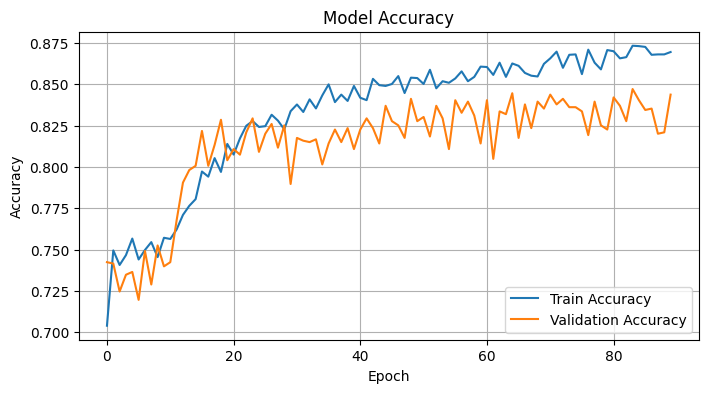

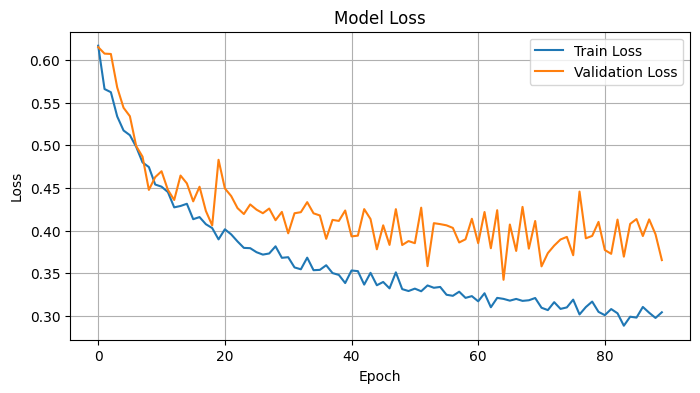

In [130]:
# Plot accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

### Visualisation des métriques : Précision, Rappel et F1-Score

Dans cette étape, nous traçons les courbes de précision, rappel et F1-score pour l'ensemble d'entraînement et l'ensemble de validation au cours des différentes époques. Ces métriques sont essentielles pour évaluer la performance du modèle, notamment dans les problèmes de classification. Le graphique affiche les évolutions de ces scores au fil des époques, ce qui permet de visualiser les progrès du modèle et de détecter d'éventuels problèmes de sur-apprentissage ou de sous-apprentissage. Les courbes sont tracées si les métriques sont présentes dans l'historique de l'entraînement (`history.history`).


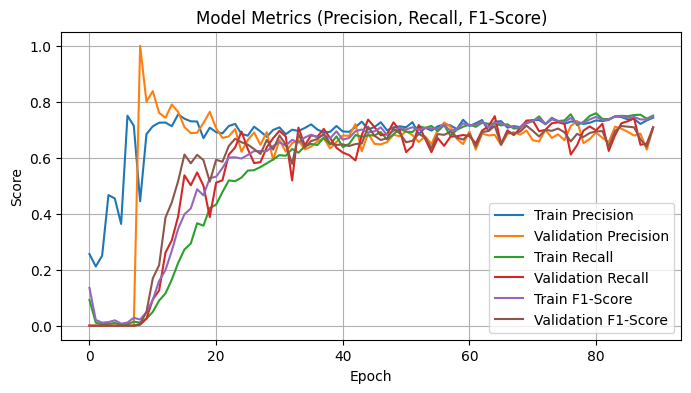

In [131]:
# Plot Precision, Recall, and F1-Score
plt.figure(figsize=(8, 4))
if 'precision' in history.history and 'val_precision' in history.history:
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')

if 'recall' in history.history and 'val_recall' in history.history:
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')

if 'f1_score' in history.history and 'val_f1_score' in history.history:
    plt.plot(history.history['f1_score'], label='Train F1-Score')
    plt.plot(history.history['val_f1_score'], label='Validation F1-Score')

plt.title('Model Metrics (Precision, Recall, F1-Score)')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Prédiction sur de nouvelles données

Dans cette section, nous utilisons le modèle entraîné pour effectuer des prédictions sur le dataset de test. Les prédictions sont générées sous forme de probabilités (dans le cadre d'une classification binaire avec la fonction sigmoid). Ces probabilités sont ensuite converties en classes binaires (0 ou 1) en appliquant un seuil de 0.5.

Le processus comprend également l'évaluation de la performance du modèle sur ce dataset en calculant :
- L'accuracy globale : la proportion de prédictions correctes.
- La précision pour chaque classe : le taux de réussite pour la classe "benign" et la classe "malignant".
- Les faux positifs et faux négatifs : pour évaluer les erreurs du modèle.

Enfin, un histogramme est tracé pour visualiser la distribution des probabilités des prédictions, ce qui permet de mieux comprendre la confiance du modèle dans ses prédictions.

Le résultat final donne des informations détaillées sur la capacité du modèle à prédire correctement les cas bénins et malins.


63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 397ms/step
Accuracy globale : 83.22%
Nombre total de cas bénins : 1471, Prédits correctement : 1274, Taux de réussite : 86.61%
Nombre total de cas malins : 526, Prédits correctement : 388, Taux de réussite : 73.76%
Faux positifs (prédits malins, mais bénins) : 197
Faux négatifs (prédits bénins, mais malins) : 138


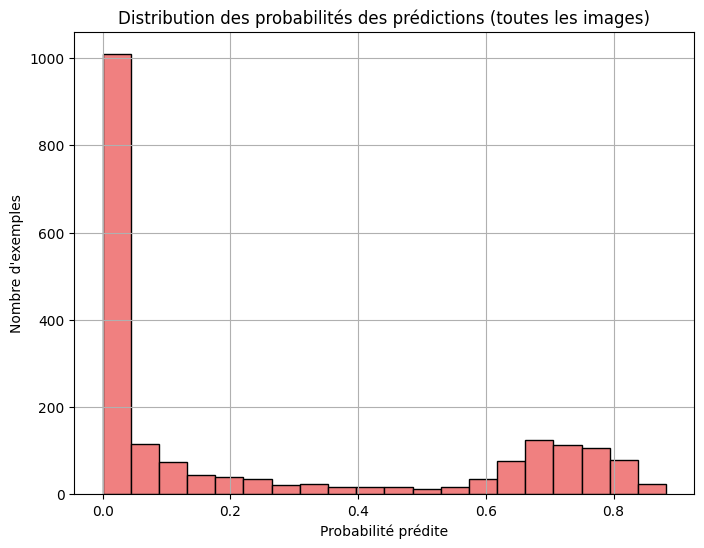

Nombre d'exemples prédits comme classe 1 : 585


In [ ]:
# Prédire les résultats sur le dataset de test
predictions = model.predict(test3_dataset)

# Classification binaire (sigmoid), les prédictions sont des probabilités
predicted_probabilities = predictions.flatten()

# Convertir les probabilités en classes binaires (0 ou 1)
predicted_classes = (predicted_probabilities >= 0.5).astype(int)

# Calculer l'accuracy globale
true_labels = metadata_clinique['label'].values  # Étiquettes réelles
accuracy = (predicted_classes == true_labels).mean()
print(f"Accuracy globale : {accuracy:.2%}")

# Calculer le nombre de bénins (classe 0) et malins (classe 1) correctement prédits
benign_correct = ((predicted_classes == 0) & (true_labels == 0)).sum()
malignant_correct = ((predicted_classes == 1) & (true_labels == 1)).sum()

# Nombre total de bénins et malins dans le dataset
benign_total = (true_labels == 0).sum()
malignant_total = (true_labels == 1).sum()

# Taux de réussite pour chaque classe
benign_accuracy = benign_correct / benign_total if benign_total > 0 else 0
malignant_accuracy = malignant_correct / malignant_total if malignant_total > 0 else 0

#Calculer les faux positifs (prédits comme 1 mais étiquetés 0) et les faux négatifs (prédits comme 0 mais étiquetés 1)
false_positives = ((predicted_classes == 1) & (true_labels == 0)).sum()
false_negatives = ((predicted_classes == 0) & (true_labels == 1)).sum()

print(f"Nombre total de cas bénins : {benign_total}, Prédits correctement : {benign_correct}, Taux de réussite : {benign_accuracy:.2%}")
print(f"Nombre total de cas malins : {malignant_total}, Prédits correctement : {malignant_correct}, Taux de réussite : {malignant_accuracy:.2%}")


print(f"Faux positifs (prédits malins, mais bénins) : {false_positives}")
print(f"Faux négatifs (prédits bénins, mais malins) : {false_negatives}")

# Tracer un histogramme des probabilités pour toutes les prédictions
plt.figure(figsize=(8, 6))
plt.hist(predicted_probabilities, bins=20, color='lightcoral', edgecolor='black')
plt.title('Distribution des probabilités des prédictions (toutes les images)')
plt.xlabel('Probabilité prédite')
plt.ylabel('Nombre d\'exemples')
plt.grid(True)
plt.show()


### Calcul et tracé de la courbe ROC

Dans cette section, nous calculons la courbe ROC (Receiver Operating Characteristic) pour évaluer la performance de notre modèle de classification binaire. La courbe ROC est un graphique qui montre la relation entre le taux de faux positifs (False Positive Rate, FPR) et le taux de vrais positifs (True Positive Rate, TPR) à différents seuils de classification.

Le processus inclut les étapes suivantes :
1. **Récupération des probabilités de prédiction** : Les scores de prédiction pour la classe positive sont extraits.
2. **Calcul de la courbe ROC** : À partir des scores de prédiction (`y_score`) et des étiquettes réelles (`y_true`), nous calculons le taux de faux positifs (FPR) et le taux de vrais positifs (TPR) en utilisant la fonction `roc_curve` de scikit-learn. Nous calculons ensuite l'aire sous la courbe (AUC) avec la fonction `auc`.
3. **Tracé de la courbe ROC** : La courbe ROC est tracée, et l'AUC (aire sous la courbe) est affichée dans la légende. Une ligne représentant une "devinette aléatoire" (aucune séparation entre les classes) est également tracée pour référence.

L'AUC (Area Under the Curve) est un indicateur clé de la performance du modèle. Une AUC proche de 1 signifie une bonne séparation entre les classes, tandis qu'une AUC proche de 0.5 indique que le modèle ne fait pas mieux qu'un tirage au sort.


[2.0732250e-02 2.3478882e-04 4.9995221e-02 ... 6.4467788e-01 7.5927460e-01
 7.0735240e-01]
[0 0 0 ... 1 1 1]


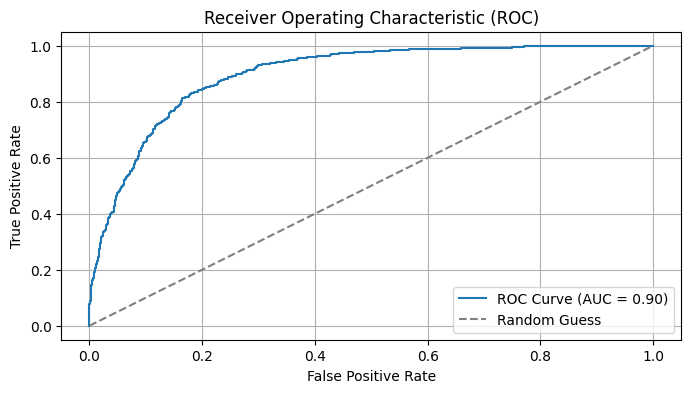

In [133]:
from sklearn.metrics import roc_curve, auc

# Courbe ROC
# Récupérer les scores de prédiction (probabilités pour la classe positive)
y_score = predictions.ravel()  # Pour binaire

# Extraire les labels vrais (en supposant que 'label' soit une colonne de test_metadata)
y_true = metadata_test2['label'].values  # C'est un tableau 1D des étiquettes de classe

print(y_score)
print(y_true)

# Calcul de la courbe ROC
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Sauvegarde du modèle entraîné

À cette étape, nous sauvegardons le modèle entraîné après avoir complété l'entraînement sur 90 époques avec un nouveau taux d'apprentissage. La méthode `model.save()` est utilisée pour enregistrer l'architecture du modèle, ses poids et la configuration d'entraînement dans un fichier. Ce fichier peut être chargé ultérieurement pour reprendre l'entraînement ou effectuer des prédictions sans avoir besoin de réentraîner le modèle depuis zéro.

Le modèle est sauvegardé sous le nom de fichier `"fine-tunning_90epochs__newlr.keras"`, ce qui permet de le retrouver facilement et d'assurer la reproductibilité des résultats.


In [134]:
model.save("fine-tunning_90epochs__newlr.keras")